# Imports

In [126]:
import transformers
import numpy as np
from transformers import AutoTokenizer,AutoModelForCausalLM,pipeline
from tqdm import tqdm
import torch
from scipy.optimize import minimize
import matplotlib.pyplot as plt

transformers.logging.set_verbosity_error()

# Load Model


In [127]:
model_name = 'Qwen/Qwen2.5-0.5B-Instruct' #Put the SLM you want here (not too big if you don't have collab gpu)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# LogProber functions

In [128]:
# Get logprobabilities on a given text
def get_logp(model,tokenizer,text):
  #get the logp for each token in text
  logp = []
  input_ids = tokenizer.encode(text)
  logits = model(torch.tensor(input_ids).unsqueeze(0)).logits
  logps = torch.nn.functional.log_softmax(logits[0,-len(input_ids):],dim=-1)
  for i in range(len(input_ids)-1):
    logp.append(logps[i,input_ids[i+1]].item())
  return [0]+logp

def plot_cumlogp(logp,tokens,show=True):
  #Plot cumulative logprobabilities with tokens on the x-axis
  n = len(logp)
  plt.plot([0]+(np.cumsum(logp[1:])).tolist(),label='data')
  plt.xticks(np.arange(len(tokens)),tokens,rotation='vertical')
  if show:
    plt.show()

def fit_model(logp):
  # Fit an exponential model on a serie of logprobabilities (the function computes the cumulative probability)
  logp = np.array([0]+np.cumsum(np.array(logp)[1:]).tolist()) #Compute the cumulative logprobability
  def loss(logp,params):
    #Computes an MSE loss
    n = len(logp)
    A,B = params
    x = np.arange(len(logp))/n #Normalize x
    y = -A*(1-np.exp(-B*x))
    l = ((logp/n-y)**2).mean()
    return l
  #Fit the model
  A,B = minimize(lambda params : loss(logp,params),
                 np.array([1,1]), #Arbitrary initialization
                 method='BFGS',
                 tol=10**-20).x
  return A,B

def plot_model(A,B,n,show=True):
  #Plot the model prediction given its parameters and an input size
  x = np.arange(n)/n
  y = -A*(1-np.exp(-B*x))
  plt.plot(x*n,y*n,label='model',linestyle='--')
  if show:
    plt.show()

## Individual plot

A: 1.2330926040749535
B: 42.321740163987464


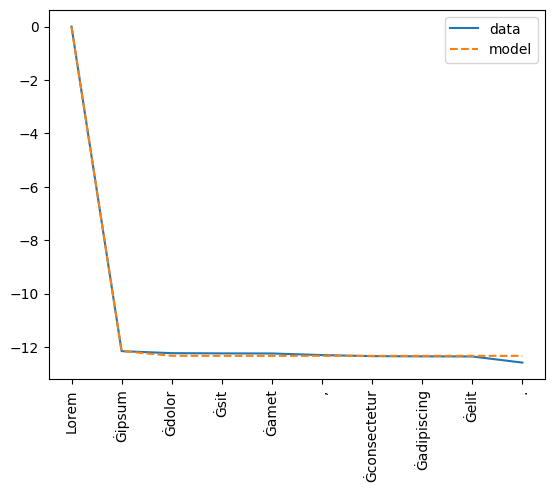

In [129]:
text = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit.'
#Compute logprobabilities for each token
logp = get_logp(model,tokenizer,text)
tokens = tokenizer.tokenize(text)
#Plot the cumulative logprobability
plot_cumlogp(logp,tokens,show=False)
#Fit the exponential model
A,B = fit_model(logp)
print('A:',A)
print('B:',B)
#Plot the exponential model
plot_model(A,B,len(logp),show=False)
plt.legend()
plt.show()

## Group plot

In [130]:
#Famous sentences. The first 3 are taken from litterature. They may or may not be known by the model. The last 3 are extremely famous on the web meaning the models should know them.
famous_texts = ['The quick brown fox jumps over the lazy dog.',
                'Lorem ipsum dolor sit amet, consectetur adipiscing elit.',
                '3.1415926535897932384626433832795028841971693993751058209749445923078164'] #Pi
#Invented or taken in the middle of random wikipedia pages without context
random_texts = ['The red carpet is more expensive than the blue one',
                'Most of the species are medium to small-sized spiders.',
                'Rescuers rappelled down the side of the bridge to the other three workers']

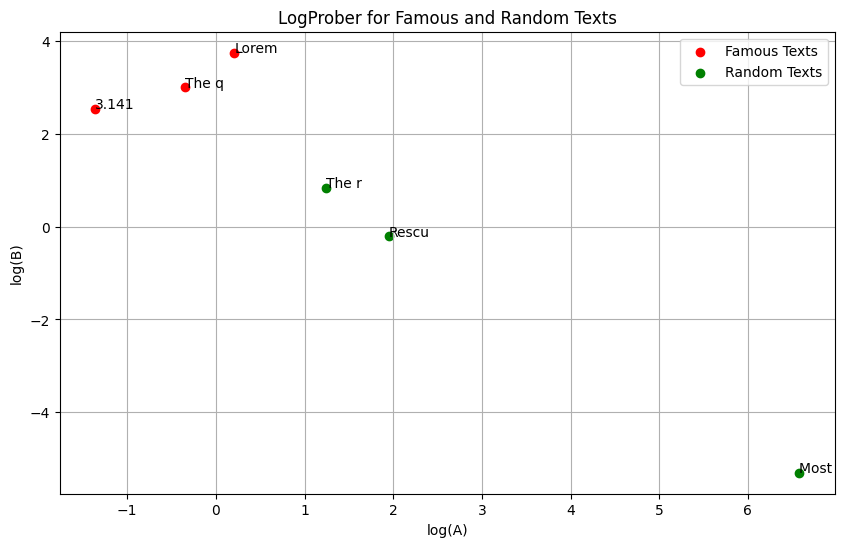

In [131]:
import numpy as np
import matplotlib.pyplot as plt

logA_famous = []
logB_famous = []
logA_random = []
logB_random = []

#Compute parameters for famous texts
for text in famous_texts:
  logp = get_logp(model, tokenizer, text)
  A, B = fit_model(logp)
  logA_famous.append(np.log(A))
  logB_famous.append(np.log(B))

#Compute parameters for non famous texts
for text in random_texts:
  logp = get_logp(model, tokenizer, text)
  A, B = fit_model(logp)
  logA_random.append(np.log(A))
  logB_random.append(np.log(B))

#Plot parameters
plt.figure(figsize=(10, 6))
plt.scatter(logA_famous, logB_famous, color='red', label='Famous Texts')
plt.scatter(logA_random, logB_random, color='green', label='Random Texts')

#Annotate scatter plots
for i, text in enumerate(famous_texts):
  plt.annotate(text[:5], (logA_famous[i], logB_famous[i]))

for i, text in enumerate(random_texts):
  plt.annotate(text[:5], (logA_random[i], logB_random[i]))

#Legend and plot
plt.xlabel('log(A)')
plt.ylabel('log(B)')
plt.title('LogProber for Famous and Random Texts')
plt.legend()
plt.grid(True)
plt.show()


### Contamination decision

In [132]:
def is_contaminated(text,model,tokenizer):
  #One can set thresholds to decide whether the model is contaminated on a given sequence
  logp = get_logp(model,tokenizer,text)
  A,B = fit_model(logp)
  if np.log(B)>1:
    return True #Pretty much sure it is contaminated
  elif np.log(B)>0:
    return None #Not sure
  return False #Pretty much sure it is not contaminated

In [133]:
texts = ['The quick brown fox jumps over the lazy dog.',
         'Lorem ipsum dolor sit amet, consectetur adipiscing elit.',
         'May the Force be with you',
         'Not all who wander are lost.',
         'To be or not to be: that is the question.',
         'Most of the species are medium to small-sized spiders.',
         'This data structure is responsive and compact.',
         'Linda is 31 years old, single, outspoken, and very bright. She majored in philosophy. As a student, she was deeply concerned with issues of discrimination and social justice, and also participated in anti-nuclear demonstrations. Which is more probable?',
        'A bat and a ball cost $1.10 in total. The bat costs $1.00 more than the ball. How much does the ball cost?',
         'If it takes 5 machines 5 minutes to make 5 widgets, how long would it take 100 machines to make 100 widgets?',
         'In a lake, there is a patch of lily pads. Every day, the patch doubles in size. If it takes 48 days for the patch to cover the entire lake, how long would it take for the patch to cover half of the lake?',
         'What is larger between a tree and a big truck ?',
         'Can an even number be prime as well as a the sum of two perfect square ?'
]

In [134]:
for i,t in enumerate(texts):
  c = is_contaminated(t,model,tokenizer)
  print('---')
  print(t)
  print('LogProber contamination :','Yes' if c else ('Unsure' if c is None else 'No'))

---
The quick brown fox jumps over the lazy dog.
LogProber contamination : Yes
---
Lorem ipsum dolor sit amet, consectetur adipiscing elit.
LogProber contamination : Yes
---
May the Force be with you
LogProber contamination : Yes
---
Not all who wander are lost.
LogProber contamination : Unsure
---
To be or not to be: that is the question.
LogProber contamination : Unsure
---
Most of the species are medium to small-sized spiders.
LogProber contamination : No
---
This data structure is responsive and compact.
LogProber contamination : No
---
Linda is 31 years old, single, outspoken, and very bright. She majored in philosophy. As a student, she was deeply concerned with issues of discrimination and social justice, and also participated in anti-nuclear demonstrations. Which is more probable?
LogProber contamination : No
---
A bat and a ball cost $1.10 in total. The bat costs $1.00 more than the ball. How much does the ball cost?
LogProber contamination : Yes
---
If it takes 5 machines 5 m